# New modulation index

In this nb, I tried to develop a new modulation index. The old modulation index uses only the firing rate (FR) info (e.g. FR when opto light was on vs. mean FR when opto light was off). In the new modulation index, a GLM gets e.g. opto info as input and predicts the firing rate of the model. If the model is highly modulated by the opto light, one would expect a high correlation between predicted and observed trace. If the cell is not modulated by the variable, one would expect that the GLM is not able to predict firing rate based on this variable (e.e. opto light), so the correlation between observed and predicted would be zero. The correlation between observed and predicted is used here as the "new MI" (modulation index).

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import scipy
import warnings
warnings.filterwarnings("ignore")

In [2]:
run -im djd.main -- --dbname=dj_hmov_dev -r

For remote access to work, make sure to first open an SSH tunnel with MySQL
port forwarding. Run the `djdtunnel` script in a separate terminal, with
optional `--user` argument if your local and remote user names differ.
Or, open the tunnel manually with:
  ssh -NL 3306:huxley.neuro.bzm:3306 -p 1021 USERNAME@tunnel.bio.lmu.de
Connecting execute@localhost:3306
Connected to database 'dj_hmov_dev' as 'execute@10.153.172.3'
For remote file access to work, make sure to first mount the filesystem at tunnel.bio.lmu.de:1021 via SSHFS with `hux -r`


In [3]:
from djd import glms
from djd import plot
from hmov_code import hmov_utils

In [4]:
def get_new_modulation_index(data, var='opto'):
    """ Fitting GLM to predict neural response based on selected variable (e.g. var='opto').
    Fitting is done with training set. Correlation between predicted and observed is done on 
    test repeats. Mean correlation of all test sets is used as the modulation index.
    
    Parameters
    ----------
    data: object
        Data object received by glms.get_hmov_data(key)
    var: str
        Can be one of 'opto', 'run', 'eye' to specify which variable the modulation index is computed.
        
    Return
    ------
    MI: float
        Modulation index for the specified variable.
    """
    from sklearn import linear_model
    assert var in ['opto', 'run', 'eye'], "var has to be one of 'opto', 'run', 'eye'"
    # Get data
    #data = glms.get_hmov_data(mseukey, split_train_val=False, verbose=False)
    y = data.responses['train']
    y_test = data.responses['test_repeats'] # List containing test repeats
    if var == 'opto':
        X = data.stimulus['opto_train'][:,np.newaxis]
        X_test = data.stimulus['opto_test_repeats'] # List containing test repeats
    elif var == 'run':
        X = data.responses['run_train'][:,np.newaxis]
        X_test = data.responses['run_test_repeats'] # List containing test repeats
    elif var == 'eye':
        X = data.responses['eye_train'][:,np.newaxis]
        X_test = data.responses['eye_test_repeats'] # List containing test repeats
    # Train GLM
    clf = linear_model.LinearRegression()
    clf.fit (X, y)
    # Make predictions and compute correlation betw. predicted and observed
    corr_coeffs = []
    for i in range(len(y_test)):
        yhat_test_repeat = clf.predict(X_test[i][:,np.newaxis])
        if np.sum(y_test[i])>0:
            corr_coeffs.append(np.corrcoef(y_test[i], yhat_test_repeat)[0,1])
    # Modulation index is the mean correlation across repeats
    MI = np.nanmean(corr_coeffs)
    return MI

In [5]:
keys = HmovUnit().get_crit_set(fr_crit=0.1, opto=True, run=True, eye=True, excl_ctrl_m=True)

In [6]:
omis_old = []
rmis_old = []
emis_old = []

omis_new = []
rmis_new = []
emis_new = []

for key in keys:
    print(key)
    data = glms.get_hmov_data(key, split_train_val=False, verbose=False)

    omi_old, rmi_old, emi_old = (HmovUnit() & key).fetch1('hmu_omi_e', 'hmu_rmi_e', 'hmu_emi_e')
    omi_new = get_new_modulation_index(data, var='opto')
    rmi_new = get_new_modulation_index(data, var='run')
    emi_new = get_new_modulation_index(data, var='eye')

    omis_old.append(omi_old)
    rmis_old.append(rmi_old)
    emis_old.append(emi_old)

    omis_new.append(omi_new)
    rmis_new.append(rmi_new)
    emis_new.append(emi_new)

{'m': 'Ntsr1Cre_2019_0007', 's': 6, 'e': 9, 'u': 1}
{'m': 'Ntsr1Cre_2019_0007', 's': 6, 'e': 9, 'u': 2}
{'m': 'Ntsr1Cre_2019_0007', 's': 6, 'e': 9, 'u': 3}
{'m': 'Ntsr1Cre_2019_0007', 's': 6, 'e': 9, 'u': 4}
{'m': 'Ntsr1Cre_2019_0007', 's': 6, 'e': 9, 'u': 5}
{'m': 'Ntsr1Cre_2019_0007', 's': 6, 'e': 9, 'u': 7}
{'m': 'Ntsr1Cre_2019_0007', 's': 6, 'e': 9, 'u': 8}
{'m': 'Ntsr1Cre_2019_0007', 's': 6, 'e': 9, 'u': 9}
{'m': 'Ntsr1Cre_2019_0007', 's': 6, 'e': 9, 'u': 10}
{'m': 'Ntsr1Cre_2019_0007', 's': 6, 'e': 9, 'u': 11}
{'m': 'Ntsr1Cre_2019_0007', 's': 6, 'e': 9, 'u': 12}
{'m': 'Ntsr1Cre_2019_0007', 's': 6, 'e': 9, 'u': 13}
{'m': 'Ntsr1Cre_2019_0007', 's': 6, 'e': 9, 'u': 14}
{'m': 'Ntsr1Cre_2019_0007', 's': 6, 'e': 9, 'u': 15}
{'m': 'Ntsr1Cre_2019_0007', 's': 6, 'e': 9, 'u': 17}
{'m': 'Ntsr1Cre_2019_0007', 's': 6, 'e': 9, 'u': 18}
{'m': 'Ntsr1Cre_2019_0007', 's': 6, 'e': 9, 'u': 20}
{'m': 'Ntsr1Cre_2019_0007', 's': 6, 'e': 9, 'u': 21}
{'m': 'Ntsr1Cre_2019_0008', 's': 3, 'e': 7, 'u': 5}
{'

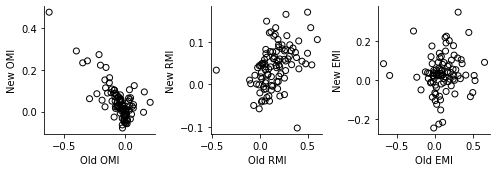

In [7]:
fig, axs = plt.subplots(1,3, figsize=(7, 2.5))

axs[0].scatter(omis_old, omis_new, edgecolor='k', color='none', lw=1)
axs[0].set_xlabel('Old OMI')
axs[0].set_ylabel('New OMI')

axs[1].scatter(rmis_old, rmis_new, edgecolor='k', color='none', lw=1)
axs[1].set_xlabel('Old RMI')
axs[1].set_ylabel('New RMI')

axs[2].scatter(emis_old, emis_new, edgecolor='k', color='none', lw=1)
axs[2].set_xlabel('Old EMI')
axs[2].set_ylabel('New EMI')

sns.despine()
fig.tight_layout()

fig.patch.set_facecolor('white')
fig.savefig('./plots/old_vs_new_MIs.png', dpi=150, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)

# Get performance improvement

In [8]:
accs_stim_only = []
accs_opto = []
accs_run = []
accs_eye = []

acc_gains_opto = []
acc_gains_run = []
acc_gains_eye = []

for key in keys:
    bm_stim_only = glms.get_best_model(key, opto_config='False', run_config='False', eye_config='False', format='dict')
    bm_opto = glms.get_best_model(key, opto_config='True', run_config='False', eye_config='False', format='dict')
    bm_run = glms.get_best_model(key, opto_config='False', run_config='True', eye_config='False', format='dict')
    bm_eye = glms.get_best_model(key, opto_config='False', run_config='False', eye_config='True', format='dict')
    # Get accuracy
    accs_stim_only.append(bm_stim_only['spl_r_test'])
    accs_opto.append(bm_opto['spl_r_test'])
    accs_run.append(bm_run['spl_r_test'])
    accs_eye.append(bm_eye['spl_r_test'])
    # Compute gains
    acc_gain_opto = np.diff([bm_stim_only['spl_r_test'], bm_opto['spl_r_test']])[0] # Gain will be positive if it got better, negative if it got worse
    acc_gain_run = np.diff([bm_stim_only['spl_r_test'], bm_run['spl_r_test']])[0]
    acc_gain_eye = np.diff([bm_stim_only['spl_r_test'], bm_eye['spl_r_test']])[0]

    acc_gains_opto.append(acc_gain_opto)
    acc_gains_run.append(acc_gain_run)
    acc_gains_eye.append(acc_gain_eye)

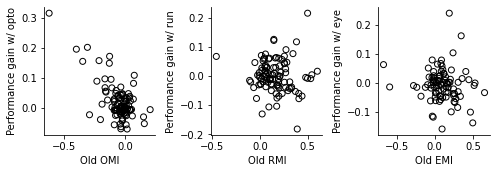

In [9]:
fig, axs = plt.subplots(1,3, figsize=(7, 2.5))

axs[0].scatter(omis_old, acc_gains_opto, edgecolor='k', color='none', lw=1)
axs[0].set_xlabel('Old OMI')
axs[0].set_ylabel('Performance gain w/ opto')

axs[1].scatter(rmis_old, acc_gains_run, edgecolor='k', color='none', lw=1)
axs[1].set_xlabel('Old RMI')
axs[1].set_ylabel('Performance gain w/ run')

axs[2].scatter(emis_old, acc_gains_eye, edgecolor='k', color='none', lw=1)
axs[2].set_xlabel('Old EMI')
axs[2].set_ylabel('Performance gain w/ eye')

sns.despine()
fig.tight_layout()

fig.patch.set_facecolor('white')
fig.savefig('./plots/oldMI_vs_perf_gain.png', dpi=150, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)

In [10]:
print('Old OMI vs. gain: r = {:.2f}'.format(np.corrcoef(omis_old, acc_gains_opto)[0,1])) 
print('Old RMI vs. gain: r = {:.2f}'.format(np.corrcoef(rmis_old, acc_gains_run)[0,1])) 
print('Old EMI vs. gain: r = {:.2f}'.format(np.corrcoef(emis_old, acc_gains_eye)[0,1])) 

Old OMI vs. gain: r = -0.66
Old RMI vs. gain: r = -0.04
Old EMI vs. gain: r = nan


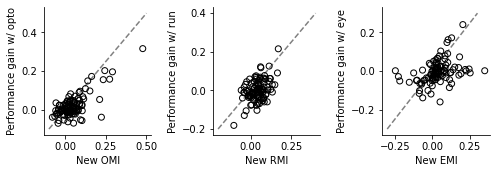

In [11]:
fig, axs = plt.subplots(1,3, figsize=(7, 2.5))

axs[0].scatter(omis_new, acc_gains_opto, edgecolor='k', color='none', lw=1)
axs[0].plot(np.linspace(-.1,.5,100), np.linspace(-.1,.5,100), color='gray', ls='--', zorder=0)
axs[0].set_xlabel('New OMI')
axs[0].set_ylabel('Performance gain w/ opto')

axs[1].scatter(rmis_new, acc_gains_run, edgecolor='k', color='none', lw=1)
axs[1].plot(np.linspace(-.2,.4,100), np.linspace(-.2,.4,100), color='gray', ls='--', zorder=0)
axs[1].set_xlabel('New RMI')
axs[1].set_ylabel('Performance gain w/ run')

axs[2].scatter(emis_new, acc_gains_eye, edgecolor='k', color='none', lw=1)
axs[2].plot(np.linspace(-.3,.3,100), np.linspace(-.3,.3,100), color='gray', ls='--', zorder=0)
axs[2].set_xlabel('New EMI')
axs[2].set_ylabel('Performance gain w/ eye')

sns.despine()
fig.tight_layout()

fig.patch.set_facecolor('white')
fig.savefig('./plots/newMI_vs_perf_gain.png', dpi=150, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)

In [12]:
print('New OMI vs. gain: r = {:.2f}'.format(np.corrcoef(omis_new, acc_gains_opto)[0,1])) 
print('New RMI vs. gain: r = {:.2f}'.format(np.corrcoef(rmis_new, acc_gains_run)[0,1])) 
print('New EMI vs. gain: r = {:.2f}'.format(np.corrcoef(emis_new, acc_gains_eye)[0,1])) 

New OMI vs. gain: r = 0.74
New RMI vs. gain: r = 0.45
New EMI vs. gain: r = 0.39


# Relate performance gains

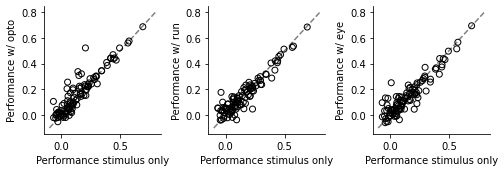

In [13]:
fig, axs = plt.subplots(1,3, figsize=(7, 2.5))

axs[0].scatter(accs_stim_only, accs_opto, edgecolor='k', color='none', lw=1)
axs[0].plot(np.linspace(-.1,.8,100), np.linspace(-.1,.8,100), color='gray', ls='--', zorder=0)
axs[0].set_xlabel('Performance stimulus only')
axs[0].set_ylabel('Performance w/ opto')

axs[1].scatter(accs_stim_only, accs_run, edgecolor='k', color='none', lw=1)
axs[1].plot(np.linspace(-.1,.8,100), np.linspace(-.1,.8,100), color='gray', ls='--', zorder=0)
axs[1].set_xlabel('Performance stimulus only')
axs[1].set_ylabel('Performance w/ run')

axs[2].scatter(accs_stim_only, accs_eye, edgecolor='k', color='none', lw=1)
axs[2].plot(np.linspace(-.1,.8,100), np.linspace(-.1,.8,100), color='gray', ls='--', zorder=0)
axs[2].set_xlabel('Performance stimulus only')
axs[2].set_ylabel('Performance w/ eye')

sns.despine()
fig.tight_layout()

fig.patch.set_facecolor('white')
fig.savefig('./plots/perf_gains.png', dpi=150, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)

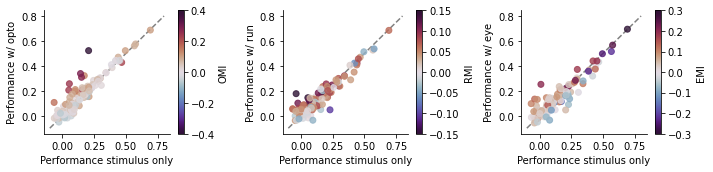

In [14]:
fig, axs = plt.subplots(1,3, figsize=(10, 2.5))

im0 = axs[0].scatter(accs_stim_only, accs_opto, c=omis_new, cmap='twilight_shifted', alpha=.8, vmin=-.4, vmax=.4)
cbar = fig.colorbar(im0, ax=axs[0])        
cbar.set_label('OMI', rotation=-270)
axs[0].plot(np.linspace(-.1,.8,100), np.linspace(-.1,.8,100), color='gray', ls='--', zorder=0)
axs[0].set_xlabel('Performance stimulus only')
axs[0].set_ylabel('Performance w/ opto')

im1 = axs[1].scatter(accs_stim_only, accs_run, c=rmis_new, cmap='twilight_shifted', alpha=.8, vmin=-.15, vmax=.15)
cbar = fig.colorbar(im1, ax=axs[1])        
cbar.set_label('RMI', rotation=-270)
axs[1].plot(np.linspace(-.1,.8,100), np.linspace(-.1,.8,100), color='gray', ls='--', zorder=0)
axs[1].set_xlabel('Performance stimulus only')
axs[1].set_ylabel('Performance w/ run')

im2 = axs[2].scatter(accs_stim_only, accs_eye, c=emis_new, cmap='twilight_shifted', alpha=.8, vmin=-.3, vmax=.3)
cbar = fig.colorbar(im2, ax=axs[2])        
cbar.set_label('EMI', rotation=-270)
axs[2].plot(np.linspace(-.1,.8,100), np.linspace(-.1,.8,100), color='gray', ls='--', zorder=0)
axs[2].set_xlabel('Performance stimulus only')
axs[2].set_ylabel('Performance w/ eye')

sns.despine()
fig.tight_layout()

fig.patch.set_facecolor('white')
fig.savefig('./plots/perf_gains_newMIs.png', dpi=150, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)

Units that have good performance in stimulus only **and** models w/ eye also seem to have a higher modulation index. 
This was confusing first but thinking about it, stimulus luminance and pupil size are correlated. So maybe adding the eye variable as input to the model does actually not provide the model with much more information since the information of the pupil size was kind of already present in the stimulus luminance.

The opto modulation index and models w/ opto behave as expected.

For running and eye it is still weird that we hve some units where the performance decreases when we add running variable as input to the model. I have to investigate this more...

### comparison with the old modulation index

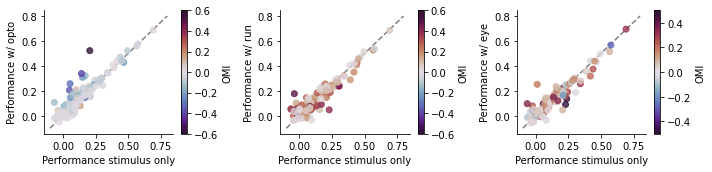

In [15]:
fig, axs = plt.subplots(1,3, figsize=(10, 2.5))

im0 = axs[0].scatter(accs_stim_only, accs_opto, c=omis_old, cmap='twilight_shifted', alpha=.8, vmin=-.6, vmax=.6)
cbar = fig.colorbar(im0, ax=axs[0])        
cbar.set_label('OMI', rotation=-270)
axs[0].plot(np.linspace(-.1,.8,100), np.linspace(-.1,.8,100), color='gray', ls='--', zorder=0)
axs[0].set_xlabel('Performance stimulus only')
axs[0].set_ylabel('Performance w/ opto')

im1 = axs[1].scatter(accs_stim_only, accs_run, c=rmis_old, cmap='twilight_shifted', alpha=.8, vmin=-.6, vmax=.6)
cbar = fig.colorbar(im1, ax=axs[1])        
cbar.set_label('OMI', rotation=-270)
axs[1].plot(np.linspace(-.1,.8,100), np.linspace(-.1,.8,100), color='gray', ls='--', zorder=0)
axs[1].set_xlabel('Performance stimulus only')
axs[1].set_ylabel('Performance w/ run')

im2 = axs[2].scatter(accs_stim_only, accs_eye, c=emis_old, cmap='twilight_shifted', alpha=.8, vmin=-.5, vmax=.5)
cbar = fig.colorbar(im2, ax=axs[2])        
cbar.set_label('OMI', rotation=-270)
axs[2].plot(np.linspace(-.1,.8,100), np.linspace(-.1,.8,100), color='gray', ls='--', zorder=0)
axs[2].set_xlabel('Performance stimulus only')
axs[2].set_ylabel('Performance w/ eye')

sns.despine()
fig.tight_layout()

fig.patch.set_facecolor('white')
fig.savefig('./plots/perf_gains_oldMIs.png', dpi=150, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)